In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from IPython.display import clear_output
from time import sleep
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline

# Define basic functionalities of RBM

In [85]:



def boltzmann_step(v, b,W, do_random_sampling = True):
    h = W@v+b[:,None]
    p = 1/(np.exp(-h)+1)
    if(do_random_sampling):
        temp = np.random.uniform(size=p.shape)
        p = np.where(temp<=p,1,0)

    return p



    
def BoltzmannSequence(v,c,b,W,drop_h_prime=False,do_random_sampling=True,
                      do_not_sample_h_prime=False,
                     do_not_sample_v_prime=False):
    
    h=boltzmann_step(v,b,W,do_random_sampling=do_random_sampling)
    if do_not_sample_v_prime:
        v_prime=boltzmann_step(h,c,W.T,do_random_sampling=False)
    else:
        v_prime=boltzmann_step(h,c,W.T,do_random_sampling=do_random_sampling)
        
    if  drop_h_prime:
        h_prime=np.zeros(np.shape(h))
    else:
        if do_not_sample_h_prime: 
            h_prime=boltzmann_step(v_prime,b,W,do_random_sampling=False)
        else:
            h_prime=boltzmann_step(v_prime,b,W,do_random_sampling=do_random_sampling)
        
    return(v,h,v_prime,h_prime)

def Train_step(v,c,b,W,do_random_sampling=True,do_not_sample_h_prime=False,
             do_not_sample_v_prime=False):
    
    n_exampels = v.shape[-1]
    
    v,h,v_prime,h_prime=BoltzmannSequence(v,c,b,W,do_random_sampling=do_random_sampling,
                                         do_not_sample_h_prime=do_not_sample_h_prime,
                                         do_not_sample_v_prime=do_not_sample_v_prime)
    
    db = np.mean(h_prime - h, axis=-1)
    dc = np.mean(v_prime - v, axis=-1)
    dw = (h@v.T - h_prime@v_prime.T)/n_exampels
    return(db,dc,dw)


# Load Mnist data_set

In [51]:
# Load the MNIST data using tensorflow/keras
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data(path="mnist.npz")

X_train=X_train/256.
X_train=X_train.T
X_train=np.swapaxes(X_train,0,1)

# Visualize data

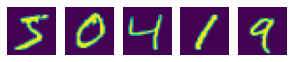

In [52]:
n_ims = 5
fig, axes = plt.subplots(ncols=n_ims,nrows=1,figsize=(n_ims,1))
for i in range(n_ims):
    axes[i].imshow(X_train[:,:,i])
    axes[i].axis('off')

In [53]:
def apply_threshold_to_x_data(x_train,threshold):
    result = np.where(x_train>threshold,1,0)
    result=np.int_(result)
    return result

In [54]:
X_train_digitized = apply_threshold_to_x_data(X_train, threshold=0.7)

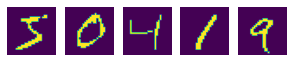

In [55]:
n_ims = 5
fig, axes = plt.subplots(ncols=n_ims,nrows=1,figsize=(n_ims,1))
for i in range(n_ims):
    axes[i].imshow(X_train_digitized[:,:,i])
    axes[i].axis('off')

# Training on digitized images

In [61]:
batchsize = 128 
n_train = 100
n_vis = 28**2
n_hid = 60
total_number_of_examples = X_train.shape[-1]

c=np.random.randn(n_vis)
b=np.random.randn(n_hid)
W=0.01*np.random.randn(n_hid,n_vis)
alpha = 0.1


In [62]:
for epoch in tqdm(range(n_train)):
    randindex = np.random.randint(low=0,high=total_number_of_examples,size=batchsize)
    v=X_train_digitized[:,:,randindex]
    v = np.reshape(v,(n_vis,batchsize))
    db,dc,dw=Train_step(v,c,b,W)
    b+=alpha*db
    c+=alpha*dc
    W+=alpha*dw

<ipython-input-50-903b5a904726>:3: RuntimeWarning: overflow encountered in exp
  p = 1/(np.exp(-h)+1)


In [81]:
batchsize = 128 
n_train = 10000
n_vis = 28**2
n_hid = 60
total_number_of_examples = X_train.shape[-1]

c=np.random.randn(n_vis)
b=np.random.randn(n_hid)
W=0.01*np.random.randn(n_hid,n_vis)
alpha = 0.1

# Training but with Adam algorithm optimization

In [87]:
mt_W = st_W = 0*W
mt_b =st_b  = 0*b
mt_c  = st_c = 0*c
epsilon = 1e-9; beta1 = 0.9; beta2 = 0.99; eta =  0.1
def apply_one_adam_step(g,mt,st):
    global epsilon, beta1, beta2, eta
    mt = beta1*mt+(1-beta1)*g
    mt_hat = mt/(1-beta1)
    st = beta2*st+(1-beta2)*g**2
    st_hat = st/(1-beta2)
    incremental_term = eta*mt_hat/np.sqrt(st_hat + epsilon)
    return (incremental_term, mt, st)

for epoch in tqdm(range(n_train)):
    randindex = np.random.randint(low=0,high=total_number_of_examples,size=batchsize)
    v=X_train_digitized[:,:,randindex]
    v = np.reshape(v,(n_vis,batchsize))
    db,dc,dw=Train_step(v,c,b,W)
    add_W, mt_W, st_W=  apply_one_adam_step(dw,mt_W,st_W)
    add_b, mt_b, st_b =  apply_one_adam_step(db,mt_b,st_b)
    add_c, mt_c, st_c =  apply_one_adam_step(dc,mt_c,st_c)
    W+=add_W
    b+=add_b
    c+=add_c

<ipython-input-85-903b5a904726>:3: RuntimeWarning: overflow encountered in exp
  p = 1/(np.exp(-h)+1)


KeyboardInterrupt: 

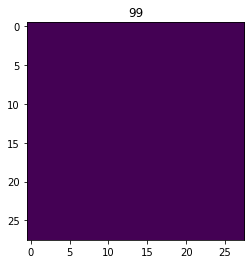

In [84]:
nsteps=100
test_samples=np.zeros([n_vis,n_hid])
skipsteps=10
substeps=10 # how many steps to take before showing a new picture

v_prime=np.zeros(n_vis)
h=np.zeros(n_hid)
h_prime=np.zeros(n_hid)
for j in tqdm(range(nsteps)):
    for k in range(substeps):
        v,h,v_prime,h_prime=BoltzmannSequence(v,c,b,W,drop_h_prime=True) # step from v via h to v_prime!
    test_samples = v[:,1]
    
    v=np.copy(v_prime) # use the new v as a starting point for next step!
    if j%skipsteps==0 or j==nsteps-1:
        clear_output(wait=True)
        plt.imshow(np.reshape(test_samples,(28,28)))
        plt.title(j)
        plt.pause(0.000001)
        
        

In [86]:
test_samples

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,